# EEG and spike trains analysis in GPe of Parkinsonian rats models
---

With this notebook, we aim at deciphering the relationship between brain waves and spike trains in neurons of the GPe, where we hypothesize to find two populations of neurons having different relationship. To do so, synchronous recordings of spike trains and EEG have been performed in mice model of Parkinson and in a control group. Here we will analyze and compare these datasets.

In [1]:
# First, load necessary libraries 
# More detailed usage of these libraries will be explained along the way, as they are used
import h5py                         # Read datasets files
import numpy as np                  # Various matrix operations
import scipy.signal as signal       # Perform signal analysis
import matplotlib.pyplot as plt     # Plot the resulting figures

### Understanding the datasets
---
We have 4 datasets containing EEG data and spike train recordings related to different conditions.
* First, using h5py, we will load these datasets in a dictionary in order to access them more easily.
* Then, we will print the list of keys associated with these datasets. As we can see, each dataset contains at least one EEG file, followed by several spike train recordings (ST). 
`EEG_file ST1 ST2 ST3 ...`
* Bellow, we will dig a bit more in these datasets in order to understand how they are built.

In [2]:
# Load the data in a dictionary
data = {
    'ActivPark': h5py.File('samples/L23_f09_as_PARK.mat','r'),
    'SWAPark': h5py.File('samples/L23_f03_swa_PARK.mat','r'),
    'ActivCtl': h5py.File('samples/A9_c05_as_CTL.mat','r'),
    'SWACtl': h5py.File('samples/A9_c01_swa_CTL.mat','r')
    }

# For latter use, we will also create a dictionary containing name that we want to give to our data
data_label = {
    'ActivPark': 'Parkison - Activation',
    'SWAPark': 'Parkison - SWA',
    'ActivCtl': 'Control - Activation',
    'SWACtl': 'Control - SWA'
    }

# Look at the variable names in each data file
for key,value in data.items():
    print(key, '\n', *data[key].keys(), end='\n\n')

ActivPark 
 L23_Beat_cycl L23_Beta_EEG L23_EEGipsi L23_Pr18_c08 L23_Pr20_c09 L23_Pr20_c0A L23_Pr20_c0B L23_Pr23_c0E L23_Pr25_c10 L23_Pr25_c11 L23_Pr26_c12 L23_SS_Pr_1 L23_SS_Pr_11 L23_SS_Pr_17 L23_SS_Pr_21 L23_SS_Pr_22 L23_SS_Pr_3 L23_SS_Pr_7 L23_SS_Pr_9

SWAPark 
 L23_EEGipsi L23_Pr20_c09 L23_Pr20_c0A L23_Pr20_c0B L23_Pr23_c0E L23_Pr23_c0F L23_Pr25_c10 L23_Pr25_c11 L23_SS_Pr_1 L23_SS_Pr_11 L23_SS_Pr_17 L23_SS_Pr_21 L23_SS_Pr_22 L23_SS_Pr_7

ActivCtl 
 A9_EEGipsi A9_P2021_c10 A9_P2021_c11 A9_Pr10_c0C A9_Pr10_c0D A9_Pr10_c0E A9_Pr17_c01 A9_Pr17_c10 A9_Pr1_c01 A9_Pr22_c12 A9_Pr22_c13 A9_Pr2_c02 A9_Pr2_c1B A9_Pr6_c05 A9_Pr8_c07 A9_Pr8_c08 A9_SS_Pr_25 A9_SS_Pr_3 A9_SS_Pr_4 A9_SS_Pr_9

SWACtl 
 A9_EEGipsi A9_P2021_c10 A9_P2021_c11 A9_Pr10_c0C A9_Pr10_c0D A9_Pr10_c0E A9_Pr1_c01 A9_Pr22_c12 A9_Pr22_c13 A9_Pr8_c07 A9_Pr8_c08 A9_Pr9_c09 A9_Pr9_c0A A9_Pr9_c0B A9_SS_Pr_11 A9_SS_Pr_2 A9_SS_Pr_25 A9_SS_Pr_3 A9_SS_Pr_4 A9_SS_Pr_6 A9_SS_Pr_7


---
We can also look deeper in the data: for each recording we have several parameters/variables. For example, in every spike trains recording we can find the following variables/keys.
- comment
- length
- resolution
- times
- title

We are mostly interested in "times", it is the firing times of every recorded spike/action potential.

In [3]:
# Look up variable in a specific spike trains dataset
print(dict(data['ActivPark']['L23_Pr20_c09']))

{'comment': <HDF5 dataset "comment": shape (33, 1), type "<u2">, 'length': <HDF5 dataset "length": shape (1, 1), type "<f8">, 'resolution': <HDF5 dataset "resolution": shape (1, 1), type "<f8">, 'times': <HDF5 dataset "times": shape (1, 725), type "<f8">, 'title': <HDF5 dataset "title": shape (8, 1), type "<u2">}


---
In the EEG dataset we have:
- comment
- interval
- length
- offset
- scale
- start
- title
- units
- values

Here, we will be mostly interested in "values", but also "interval".

In [4]:
# Look up variable in a specific EEG dataset
print(dict(data['ActivPark']['L23_EEGipsi']))

{'comment': <HDF5 dataset "comment": shape (10, 1), type "<u2">, 'interval': <HDF5 dataset "interval": shape (1, 1), type "<f8">, 'length': <HDF5 dataset "length": shape (1, 1), type "<f8">, 'offset': <HDF5 dataset "offset": shape (1, 1), type "<f8">, 'scale': <HDF5 dataset "scale": shape (1, 1), type "<f8">, 'start': <HDF5 dataset "start": shape (1, 1), type "<f8">, 'title': <HDF5 dataset "title": shape (7, 1), type "<u2">, 'units': <HDF5 dataset "units": shape (2, 1), type "<u2">, 'values': <HDF5 dataset "values": shape (1, 35715), type "<f8">}


## Get a first glance at the data
---

In order to get a better understanding of what we are doing, let's take a look at our data for one condition (parkisonian rats in activated mode).

In [5]:
# Select a few datasets to work with: 
# EEG and 3 spike trains from parkinsonian animals in 'activated state'

eeg_activ_park=data['ActivPark']['L23_EEGipsi']
ST1=data['ActivPark']['L23_Pr20_c09']
ST2=data['ActivPark']['L23_Pr20_c0A']
ST3=data['ActivPark']['L23_Pr20_c0B']

#### What do we have in our EEG?
First, let's examine our EEG data: how many points do we have, what is the duration of the recordings, what does it look like?

Number of sampling points: 35715 
Recording duration: 100 s


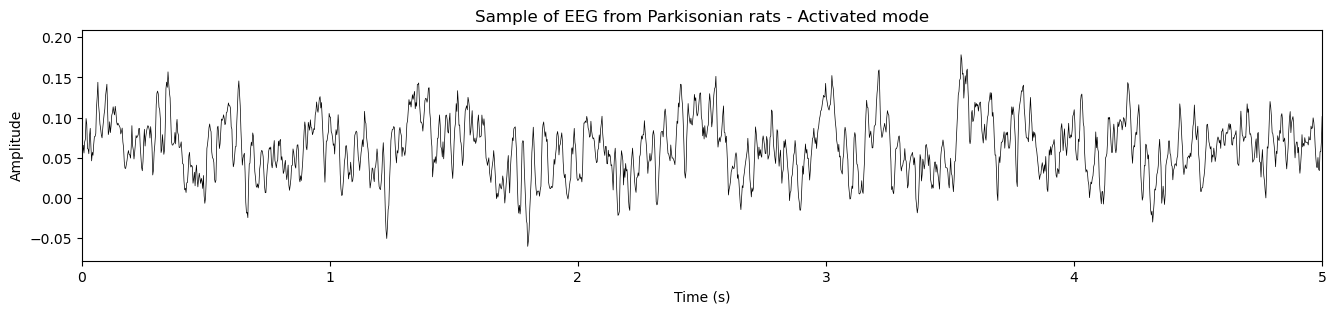

In [6]:
# Find the number of sampling points in EEG trace (size of EEG[values])
# Note that this value is also given in EEG['length'][0][0]
eeg_number_sampling_points = eeg_activ_park['values'].size
print('Number of sampling points: {} '.format(eeg_number_sampling_points))

# Then, find the duration of the recording as number of points time sampling interval (eeg[interval])
eeg_sampling_interval = eeg_activ_park['interval'][0][0]
eeg_duration = eeg_sampling_interval * eeg_number_sampling_points
print('Recording duration: {:.0f} s'.format(eeg_duration))

# Bonus step : let's look at this EEG
plt.figure(figsize=(16,3))
plt.plot(np.linspace(0, eeg_duration, eeg_number_sampling_points), eeg_activ_park['values'][0], color='k', linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
# It is a bit much packed, so let's zoom on the first 10 seconds:
plt.xlim(0, 5)
plt.title('Sample of EEG from Parkisonian rats - Activated mode')
plt.show()

In [7]:
# Look up the 1000 first points in EEG trace
eeg_first_1000 = eeg_activ_park['values'][0][:1000]
print(eeg_first_1000)

[ 0.04707336  0.05592346  0.06561279  0.05592346  0.06973267  0.07324219
  0.09887695  0.0919342   0.06164551  0.06080627  0.05500793  0.07705688
  0.08666992  0.06370544  0.04615784  0.0567627   0.05310059  0.06660461
  0.07629395  0.07659912  0.08026123  0.11238098  0.12542725  0.14404297
  0.11634827  0.10604858  0.0920105   0.08583069  0.07835388  0.07476807
  0.08636475  0.0958252   0.10437012  0.11070251  0.12664795  0.13458252
  0.14160156  0.10757446  0.07881165  0.08300781  0.09483337  0.08132935
  0.08934021  0.10299683  0.10620117  0.11352539  0.10719299  0.1033783
  0.11413574  0.10688782  0.09483337  0.09078979  0.09307861  0.09101868
  0.08956909  0.08743286  0.07965088  0.08262634  0.08705139  0.06988525
  0.06263733  0.04501343  0.03723145  0.03662109  0.04165649  0.04684448
  0.05462646  0.05905151  0.05401611  0.05378723  0.04951477  0.06324768
  0.09002686  0.06515503  0.05973816  0.04844666  0.05683899  0.06797791
  0.07766724  0.07507324  0.0769043   0.07843018  0.

---
#### Now let's take a look at our spike trains

Let's look at what we can find into the first spike trains files...

Number of spikes: 725
Time resolution: 1.6e-06


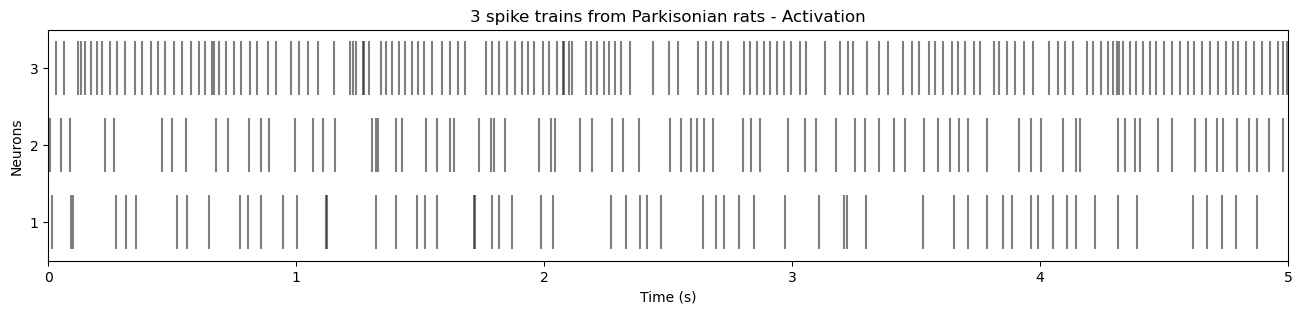

In [8]:
# First, print basic characteristics about our signal:
print('Number of spikes:', ST1['times'].size)
print('Time resolution:', ST1['resolution'][0][0])

# So, we have a set of spike times.
# We can display spike times of our three recordings on a raster plot
plt.figure(figsize=(16,3))
plt.eventplot(([],ST1['times'][0], ST2['times'][0], ST3['times'][0]), alpha=0.5, colors='k', linelengths=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Neurons')
plt.yticks([1,2,3])
plt.title('3 spike trains from Parkisonian rats - Activation')
# Let's zoom in
plt.xlim(0, 5)
plt.ylim(0.5, 3.5)
plt.show()

# It's time to process some data to get nice figures
---

## Power spectral density histogram
Here, we want to see the waves defining the two state that we will study here: SWA and "activation". These two brain states are defined by cortical oscillations of different frequencies and amplitudes. As brain waves are characterized by their frequencies, we want to analyse EEG recordings in order to break down the signal into its frequency components. To do so, we will compute the spectral density of our signal through a Welsh analysis. This type of analysis give us the power (amplitude) per frequency.

In order to get a better understanding on what is happening, we are going to perform this analysis on the 4 files we have: Parkisonian and control rats, in both activated and SWA recordings.

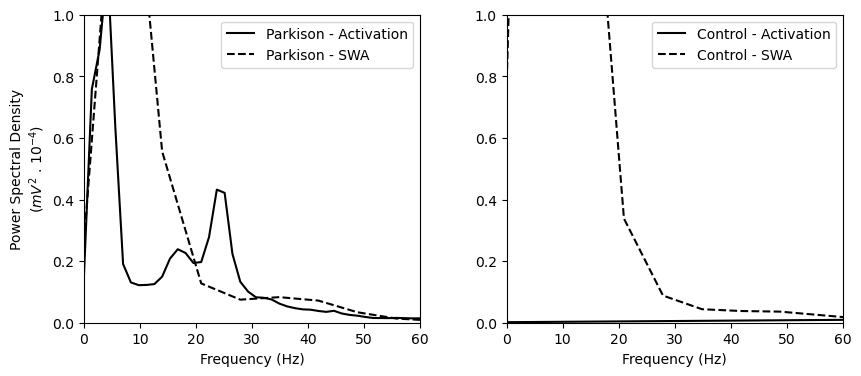

In [9]:
# Compute the spectral power density histogram (spectrum) of the EEG trace using scipy.signal.welch

# Initialize figure (size, axis)
plt.figure(figsize=(10,4))
ax = None
index = 0

# Do we have data to stack on each other? (Not yet we are just starting)
stack_data = False

# Load data for each group
for data_file in data:

    # Get the EEG recordings for each group
    # First find EEG filename among other keys, we are taking the first key that is containing "EEGipsi"
    eeg_filename = next(file_name for file_name in list(data[data_file].keys()) if "EEGipsi" in file_name)

    # Then select the EEG file in the dictionary and the associated EEG dataset
    eeg_file = data[data_file][eeg_filename]

    # Compute basic EEG data
    eeg_values = eeg_file['values'][0]
    eeg_frequency = 1 / eeg_file['interval'][0]

    # Compute the spectral power density
    eeg_spd_frequencies, eeg_spd = signal.welch(eeg_values, fs=eeg_frequency)

    # if we already have some data, then plot the second set of data
    if stack_data:
        # Plot the result
        ax.plot(eeg_spd_frequencies, eeg_spd * 10000, color='k', linestyle="--", label=data_label[data_file])
        ax.legend()
        stack_data= False

    # else, create the plot and tell that we are waiting for more data to be stacked on top
    else:
        # Plot the result
        ax = plt.subplot(1, 2, int(1+index/2), aspect=55, sharey=ax)
        ax.plot(eeg_spd_frequencies, eeg_spd * 10000, color='k', label=data_label[data_file])
        ax.set_ylim(0,1)
        ax.set_xlim(0,60)
        # y label only for the first panel
        if index == 0: ax.set_ylabel('Power Spectral Density\n($mV^2$ . $10^{-4}$)')
        ax.set_xlabel('Frequency (Hz)')
        stack_data= True
        
    index += 1

plt.show()

On this figure, with our data, we can clearly see abnormal beta-waves (frequency band around 20 Hz) in Parkinsonian rats, only in the activated mode. Because the difference between population of neurons is exacerbated in Parkinson, from now on, we will only look at the Parkisonian rats.
 
## Spike trains
---

Then, we want to get a better understanding of the relationship between neurons. We want to try how neurons fire relative to each other. To do so, we might want to look at their firing frequency through the time. Therefore, let's perform some cross-correlation and coherence analysis. Their specific purpose will be described along the way. 

But first, before performing these two analysis, let's look at these firing rate.

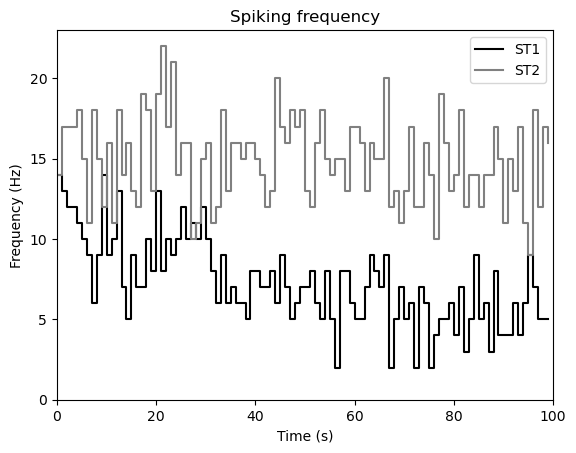

In [10]:
# Look up spike times for the two spike trains
# See above (raster plots)

# Display the times for the 2 firsts spike train (actually, we will plot them)
#plt.hist((ST1['times'][0], ST2['times'][0]), bins=100, label=("ST1","ST2"))
plt.plot(np.histogram(ST1['times'][0], bins=100)[0], label='ST1', drawstyle="steps-post", color='k')
plt.plot(np.histogram(ST2['times'][0], bins=100)[0], label='ST2', drawstyle="steps-post", color='gray')
plt.legend()
plt.xlim(0, 100)
plt.ylim(0)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spiking frequency')
plt.show()

So, it is not very clear from naked eyes whether or not these two neurons are related: we should let the computer do analysis we previously mentioned. 

## Cross-correlation between spike trains
---

The cross-correlation represent the firing probability of a neuron relative to the time a reference neuron fire. It will tell how much 2 neurons are related in the time domain. To test for correlation between two neurons, we first need to get the instantaneous firing rate of the two neurons.

In [11]:
# Make an instantaneous firing rate in bins of 1 ms using the function np.histogram

# Since we will need this data for every spike trains, let's build a function returning the instantaneous firing rate
def get_inst_fire_rate (spike_train_data, bins_size=1):
    # Compute the number of bins regarding the length of the recordings (assuming eeg and spike trains last the same) and the desired bin size (default = 1)
    # Here every recordings last 100 s, so we could also hard-code it
    nbr_bins= int(eeg_duration * 1000 / bins_size)
    # Return the instantaneous firing rate regarding the given spike trains data
    return np.histogram(spike_train_data['times'][0], bins=nbr_bins)[0] / bins_size

# Compute instantaneous firing rate of our 3 samples
inst_fire_rate_1 = get_inst_fire_rate(ST1)
inst_fire_rate_2 = get_inst_fire_rate(ST2)
inst_fire_rate_3 = get_inst_fire_rate(ST3)

Then, we can compute the cross-correlation between two time-series of instantaneous spike frequency that we just computed.

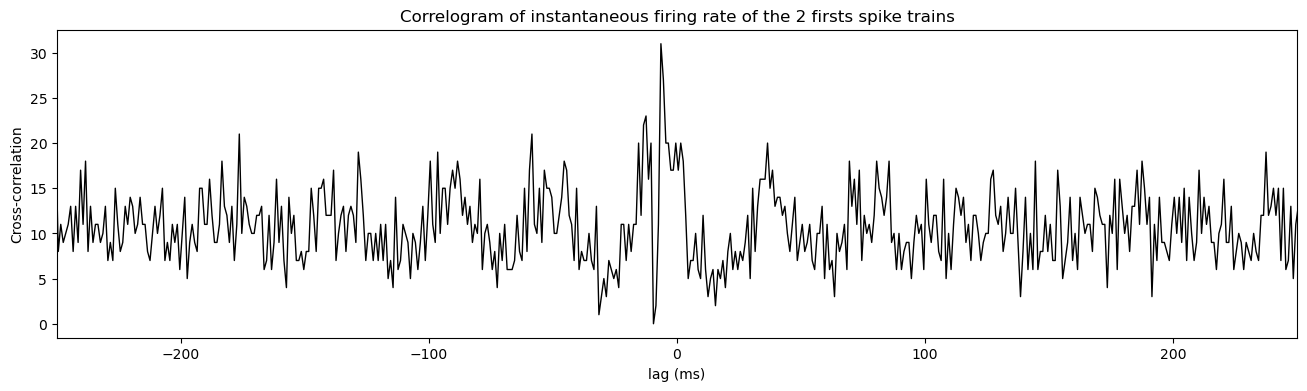

In [12]:
# Plot the cross-correlogram of instantaneous firing rate (IFR) of spike train 1 and IFR of spike train 2 for delays from -250ms to +250ms

# Cross-correlation of the two first instantaneous firing rate
cross_corr_12 = signal.correlate(inst_fire_rate_1, inst_fire_rate_2)

# In order to plot the resulting cross-correlogram with a proper x-axis, we will need to compute the time series
correlogram_length = len(cross_corr_12)
cross_corr_lag_vector = np.linspace(-correlogram_length/2+1, correlogram_length/2, correlogram_length)

# Plot the cross-correlogram
plt.figure(figsize=(16,4))
plt.plot(cross_corr_lag_vector, cross_corr_12, color='k', linewidth=1, label='Correlation')
plt.xlim(-250, 250)
plt.xlabel('lag (ms)')
plt.ylabel('Cross-correlation')
plt.title('Correlogram of instantaneous firing rate of the 2 firsts spike trains')
plt.show()

As the signal is a bit flickering, we then want to smooth it.

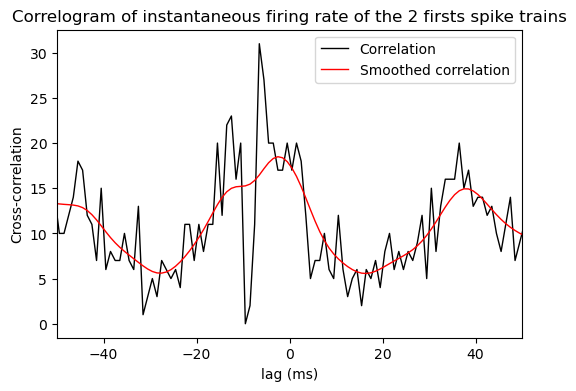

In [13]:
# Smooth the crosscorrelogram of instantaneous firing rate (IFR) of spike train 1 and IFR of spike train 2 
# and plot for delays from -50ms to +50ms

# In order to smooth the signal we will convolve a Gaussian over our signal
# First, we compute the time window over which to build the Gaussian
window = np.arange(-10,10,0.1)
# Then, compute the gaussian it-self
gaussian = np.exp(-(window/0.5)**2)
# Lastly, smooth the signal with a convolution:
smooth_cross_corr_12 = np.convolve(cross_corr_12, gaussian, mode="same") / np.sum(gaussian)

# Plot the resulting smoothed signal
plt.figure(figsize=(6,4))
plt.plot(cross_corr_lag_vector, cross_corr_12, label='Correlation', color='k', linewidth=1)
plt.plot(cross_corr_lag_vector, smooth_cross_corr_12, label='Smoothed correlation', color='r', linewidth=1)
plt.xlim(-50,50)
plt.xlabel('lag (ms)')
plt.ylabel('Cross-correlation')
plt.title('Correlogram of instantaneous firing rate of the 2 firsts spike trains')
plt.legend()
plt.show()

So, it seems that neurons 1 and 2 are a bit correlated in the time domain. Let's see what's happen if we compare neurons 2 and 3:

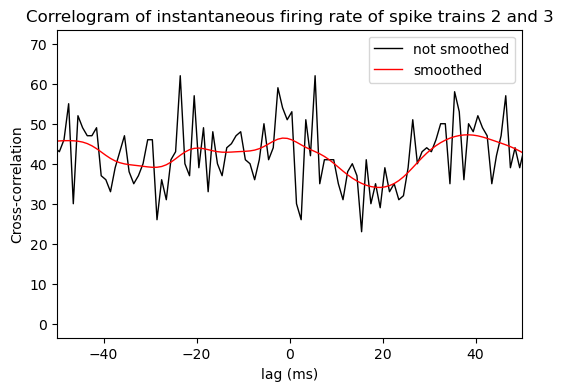

In [14]:
# Repeat the same procedure (cells 11 and 12) for spike trains 2 and 3

# Compute the cross-correlation of neurons 2 and 3
cross_corr_23 = signal.correlate(inst_fire_rate_2, inst_fire_rate_3)
# Smooth the resulting function
smooth_cross_corr_23 = np.convolve(cross_corr_23, gaussian, mode="same") / np.sum(gaussian)

# Plot the resulting curves
plt.figure(figsize=(6,4))
plt.plot(cross_corr_lag_vector, cross_corr_23, label='not smoothed', color='k', linewidth=1)
plt.plot(cross_corr_lag_vector, smooth_cross_corr_23, label='smoothed', color='r', linewidth=1)
plt.xlim(-50,50)
plt.xlabel('lag (ms)')
plt.ylabel('Cross-correlation')
plt.title('Correlogram of instantaneous firing rate of spike trains 2 and 3')
plt.legend()
plt.show()

Conversely, here, neurons 2 and 3 seems rather unrelated in the time domain. 

Now, let's look at this data for every neurons...

In [15]:
# Repeat the procedure (cell 11 and 12) for all pairs of spike trains recorded in this file (ActivPark)

# Select all spike trains samples (first 3 signals correspond to EEG)
st_keys = list(data['ActivPark'].keys())[3:]
print('Spike trains cross correlation for ActivPark\n{} samples'.format(len(st_keys)))

# Loop through all spike trains
for st_key_1 in st_keys:
        
    # Get the first spike trains data and IFR
    ifr_1 = get_inst_fire_rate(data['ActivPark'][st_key_1])
    
    # Loop again through all spike trains
    for st_key_2 in st_keys:
        
        # Do not compute cross-correlation on itself
        if st_key_1 == st_key_2: continue

        # Get the second spike trains data and IFR
        ifr_2 = get_inst_fire_rate(data['ActivPark'][st_key_2])

        # Compute cross-correlogram
        cross_corr = signal.correlate(ifr_1, ifr_2)
        
        # Value at 0 time lag
        cross_corr_0s = cross_corr[int(len(cross_corr)/2)]


print('done')
# TODO: how do we use that?

Spike trains cross correlation for ActivPark
16 samples
done


So, we have some neurons that are related to each other, some other seems to be totally unrelated.

## Coherence
---

Now, let's take a look at neurons relationship in the frequency domains: does neurons fire at the same frequency?

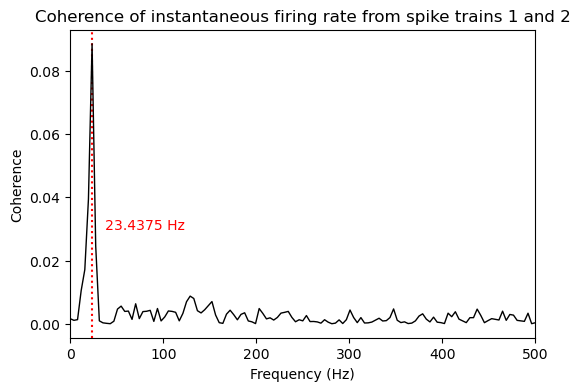

In [16]:
# Look at the coherence between instantaneous firing rate (IFR) of spike train 1 and IFR of spike train 2 with function scipy.signal.coherence
# fs = sampling frequency of series. Here sample size is 1 ms, so we have 1000 samples/s (1000 Hz)
coherence_12 = signal.coherence(inst_fire_rate_1, inst_fire_rate_2, fs=1000)

# Get the peak coherence (maximal coherence)
max_coherence_12_index = coherence_12[1].argmax()
max_coherence_12_frequency = coherence_12[0][max_coherence_12_index]

# Plot the coherence graph
plt.figure(figsize=(6,4))
# Plot a vertical line at maximal coherence
plt.axvline(max_coherence_12_frequency, linestyle=':', color='r')
plt.text(max_coherence_12_frequency,0.03, '   {} Hz'.format(max_coherence_12_frequency), color='r')
plt.plot(coherence_12[0], coherence_12[1], color='k', linewidth=1)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')
plt.xlim(0, 500)
plt.title('Coherence of instantaneous firing rate from spike trains 1 and 2')
plt.show()

Here we can see that neurons 1 and 2 seems to share a common firing rate of 23,4 Hz.

Let's compare firring time of EEG with spike rate. First, we need to resample instantaneous firing rate in order to match the EEG sampling rate. To do so we will just reuse the function we had previously made. Easy ;)

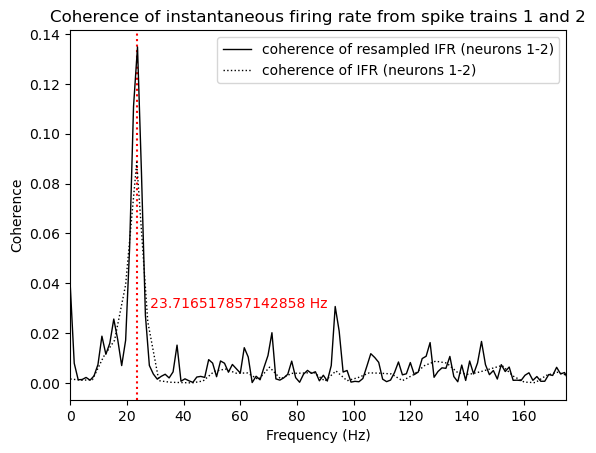

In [17]:
# We now want to compute the coherence between the EEG and the firing rates of single spike trains. 
# However, the coherence needs to be computed on signals that have the same sampling interval/rate

# First step: Recompute the IFR for a time bin similar to EEG sampling interval
inst_fire_rate_1_resampled = get_inst_fire_rate(ST1, eeg_sampling_interval*1000)
inst_fire_rate_2_resampled = get_inst_fire_rate(ST2, eeg_sampling_interval*1000)

# Second step: Look at the coherence between instantaneous firing rate (IFR) of spike train 1 and IFR of spike train 2 with new time bin
# Frequency (fs) = 1 / sampling rate
coherence_12_resampled = signal.coherence(inst_fire_rate_1_resampled, inst_fire_rate_2_resampled, fs=1/eeg_sampling_interval)

# Get the new coherence peak
max_coherence_12_resampled_index = coherence_12_resampled[1].argmax()
max_coherence_12_resampled_frequency = coherence_12_resampled[0][max_coherence_12_resampled_index]

# Plot a vertical line at maximal coherence and get the corresponding frequency
plt.axvline(max_coherence_12_resampled_frequency, linestyle=':', color='r')
plt.text(max_coherence_12_resampled_frequency,0.03, '   {} Hz'.format(max_coherence_12_resampled_frequency), color='r')

# Plot the resulting signal
plt.plot(coherence_12_resampled[0], coherence_12_resampled[1], color='k', linewidth=1, label='coherence of resampled IFR (neurons 1-2)')
plt.plot(coherence_12[0], coherence_12[1], color='k', linewidth=1, linestyle=':', label='coherence of IFR (neurons 1-2)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')
plt.xlim(0, 175)
plt.title('Coherence of instantaneous firing rate from spike trains 1 and 2')
plt.legend()
plt.show()

As we can see, despite the resampling, the peak of frequency coherence is barely changed. Therefore, we can safely resample our data.

Now we can compute the coherence between instantaneous firing rate (IFR) of a spike train and the EEG

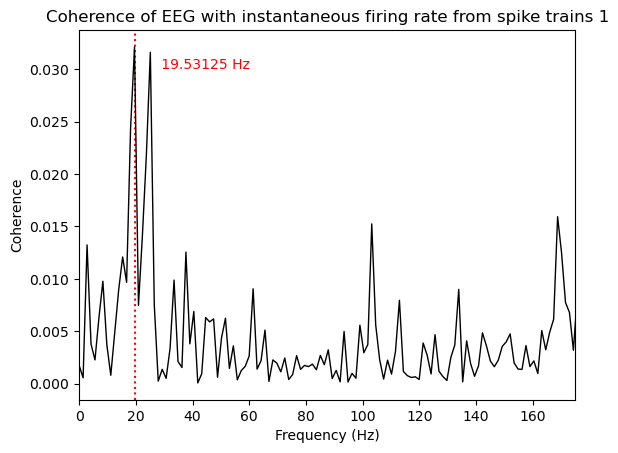

In [18]:
# Compute the coherence between instantaneous an IFR and the EEG
coherence_1_eeg = signal.coherence(inst_fire_rate_1_resampled, eeg_activ_park['values'], fs=1/eeg_sampling_interval)

# Compute the peak coherence
coherence_1_eeg_index = coherence_1_eeg[1][0].argmax()
max_coherence_1_eeg_frequency = coherence_1_eeg[0][coherence_1_eeg_index]

# Plot a vertical line at maximal coherence and get the corresponding frequency
plt.axvline(max_coherence_1_eeg_frequency, linestyle=':', color='r')
plt.text(max_coherence_1_eeg_frequency,0.03, '      {} Hz'.format(max_coherence_1_eeg_frequency), color='r')

# Plot the coherence graph
plt.plot(coherence_1_eeg[0], coherence_1_eeg[1][0], color='k', linewidth=1)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')
plt.xlim(0, 175)
plt.title('Coherence of EEG with instantaneous firing rate from spike trains 1')
plt.show()

Interestingly, neurons and EEG recordings seems to share a frequency in the frequency band of the beta oscillations.

# Spike triggered average and neuronal population
---

Until now, we only looked at the "activated" state, let's take a look at the slow waves activity...

EEG sampling rate: 1786 Hz


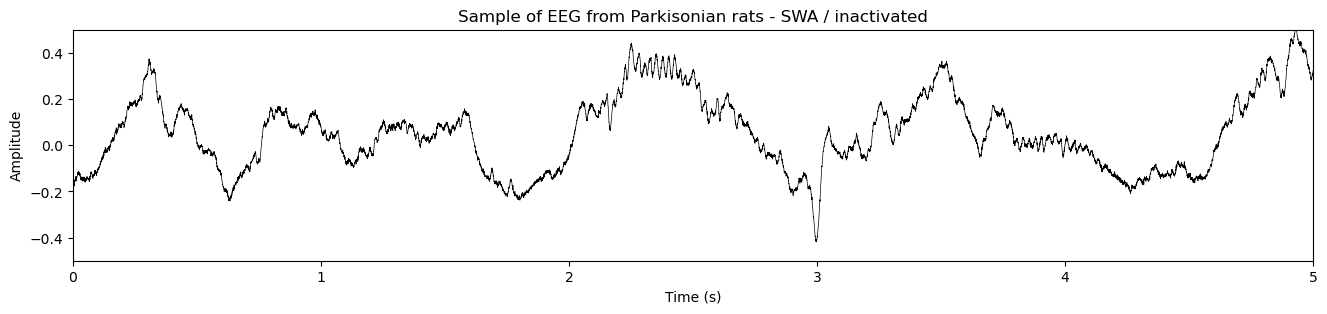

In [19]:
# Let's now look up a file with SWA activity in the cortex, and plot the 5 first seconds of this EEG
eeg_swa_park=data['SWAPark']['L23_EEGipsi']
eeg_data=eeg_swa_park['values'][0]
eeg_interval=eeg_swa_park['interval'][0][0]
print('EEG sampling rate: {:.0f} Hz'.format(1/eeg_interval))

eeg_data_5 = eeg_data[:int(5/eeg_interval)]
plt.figure(figsize=(16,3))
plt.plot(np.linspace(0, 5, len(eeg_data_5)), eeg_data_5, color='k', linewidth=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, 5)
plt.ylim(-0.5, 0.5)
plt.title('Sample of EEG from Parkisonian rats - SWA / inactivated')
plt.show()

This EEG is way more harmonious than the activated state in the sense that we can clearly see oscillations. These are the slow waves of the "SWA", we can try to extract them by filtering oscillations around 1 Hz. To do so, we will use a band-pass filter between 0.5 and 1.5 Hz.

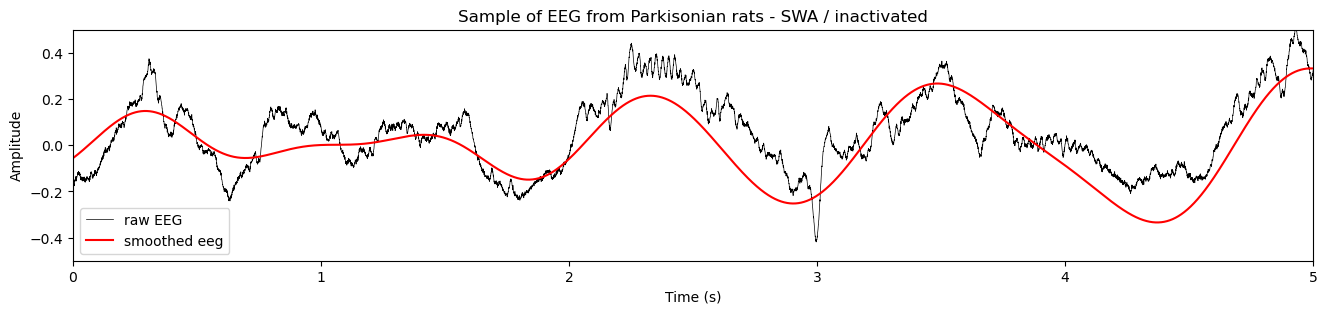

In [20]:
# Build a band pass filter with [0.5 1.5] Hz band for EEG using
slow_waves_filter = signal.butter(3, [0.5, 1.5], btype='bandpass', fs=1/eeg_interval)

# Filter EEG with scipy.signal.filtfilt
eeg_slow_waves = signal.filtfilt(slow_waves_filter[0], slow_waves_filter[1], eeg_data)

# Plot the resulting filtered signal
plt.figure(figsize=(16,3))
plt.plot(np.linspace(0, 5, len(eeg_data_5)), eeg_data_5, color='k', linewidth=0.5, label='raw EEG')
plt.plot(np.linspace(0, 5, len(eeg_data_5)), eeg_slow_waves[:int(5/eeg_interval)], color='r', label='smoothed eeg')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, 5)
plt.ylim(-0.5, 0.5)
plt.title('Sample of EEG from Parkisonian rats - SWA / inactivated')
plt.legend()
plt.show()

## Spike triggered average
---

Lastly, we want to test the relationship between neurons and these slow waves. Therefore, we want to compute te spike-triggered average (STA).

First, let's look at the STA for one single spike trains:

Number of spikes: 3294


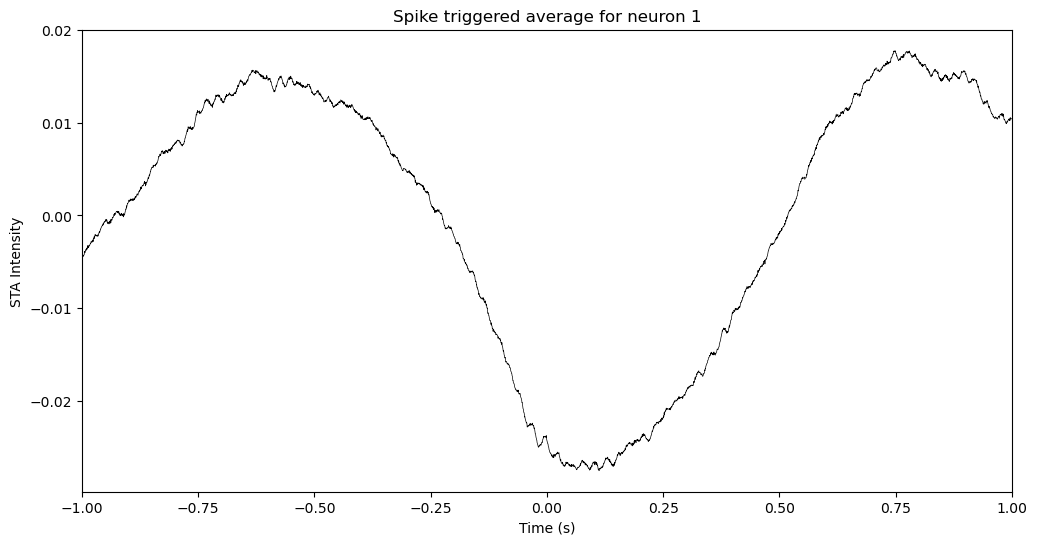

Spike-triggered average at 0 time lag: -0.024225651780057977


In [21]:
# Load one spike train and the EEG values and sampling interval from the SWAPark file
ST1 = data['SWAPark']['L23_Pr20_c09'] 
ST1_times = ST1['times'][0]
print("Number of spikes: {}".format(len(ST1_times)))

# Compute the spike-triggered average of the eeg trace with the first spike train
# To do so, we will move a "reader head" above the signal 

# First, let's set up some parameters regarding this "reader head"
# window_sec is the duration over which we will compute the average
window_sec = 2
# window_int is the number of data-point in window_sec
window_int = window_sec / eeg_interval
# time_vector is the list of timing relative to these data-points
time_vector = np.arange(-window_sec/2, window_sec/2-eeg_interval, eeg_interval)


# Since we will reuse that, we will already build a function
def get_spike_triggered_average(spike_trains_times):

    # Init the "STS" with a null matrix
    spike_triggered_sum = np.zeros(int(window_int))

    # Then we need to compute the window over which we will move our reader head.
    # Find the smallest spike time so centering the reader head on it will not make the reader head exceed our recordings
    min_index = np.argmin(np.abs(spike_trains_times-window_sec))
    # Find the biggest spike time so 
    max_index = np.argmin(np.abs(spike_trains_times-(len(eeg_data)*eeg_interval-window_sec)))
    # In other words we are searching the smallest spike time and the biggest spike time for which we have a full EEG recording one second before and after

    # If we want, we can print times related to these index
    # print("First spike in the reading range", spike_trains_times[min_index])
    # print("Last spike in the reading range", spike_trains_times[max_index])

    # Loop through the reading window (one loop per spike in this range):
    for i in range(min_index, max_index):
        # On each loop, add to the sum vector the amplitude of the EEG in the sliding reader head
        # First convert spike time into the synchronous EEG index
        eeg_index = int(spike_trains_times[i+1]/eeg_interval)
        # Select only relevant data (eeg data in the reading window) and at them to the sum
        spike_triggered_sum += eeg_data[eeg_index-int(window_int/2)-1 : eeg_index+int(window_int/2)]

    # Convert the sum into an average
    spike_triggered_average = spike_triggered_sum / (len(spike_trains_times)-2)

    # Normalize the STA to center it on 0
    spike_triggered_average = spike_triggered_average - np.mean(spike_triggered_average)
    return spike_triggered_average


# Get the STA for the first set of data
STA_1 = get_spike_triggered_average(ST1_times)

# Plot the resulting curve
plt.figure(figsize=(12,6))
plt.plot(time_vector, STA_1, color='k', linewidth=0.5)
plt.xlim(-1,1)
plt.xlabel('Time (s)')
plt.ylabel('STA Intensity')
plt.title('Spike triggered average for neuron 1')
plt.show()

# Value of the spike-triggered average at 0 time lag
print("Spike-triggered average at 0 time lag:", STA_1[int(window_int/2)])

Now, we can repeat that for every neuron.
Compute and plot the spike-triggered averages of the EEG with respect to all spike trains recorded in this SWAPark file

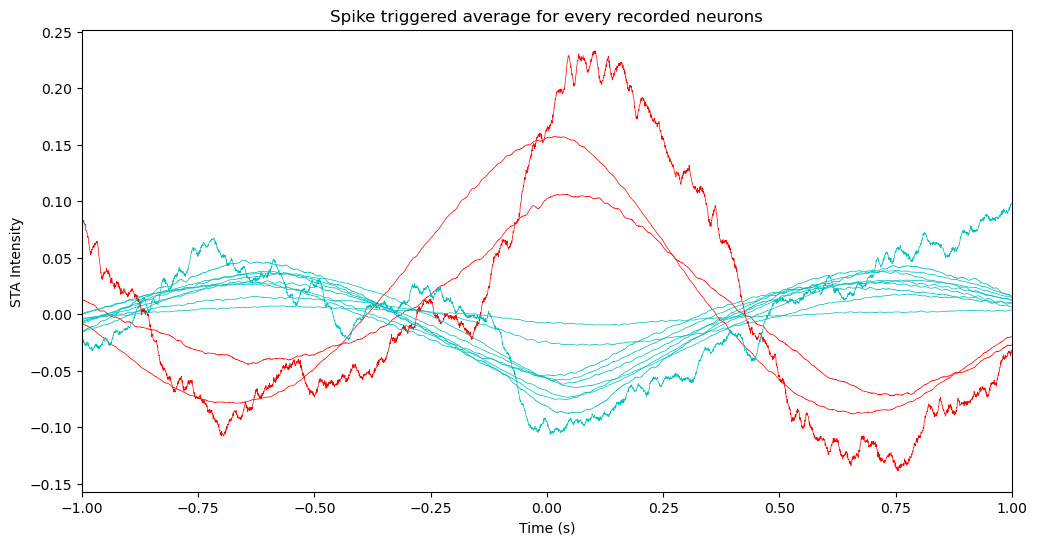

In [22]:
# Select all spike trains samples (the first signal correspond to EEG)
STs = list(data['SWAPark'])[1:]

# Init the list that will store the STA for every neuron
STAs = []

# Init the figure
plt.figure(figsize=(12,6))
plt.xlim(-1,1)
plt.xlabel('Time (s)')
plt.ylabel('STA Intensity')
plt.title('Spike triggered average for every recorded neurons')

# Loop through every neuron
for spike_key in STs:
    
    # Get spike times
    ST_times = data['SWAPark'][spike_key]['times'][0]

    # Compute the STA
    STA = get_spike_triggered_average(ST_times)

    # Value of the spike-triggered average at 0 time lag
    STA_0s = STA[int(window_int/2)]
    STAs.append(STA_0s)
    
    # Plot the STA with a different color depending on the sign of the value
    color = 'c' if STA_0s < 0 else 'r'
    plt.plot(time_vector, STA, color=color, alpha=1, linewidth=0.5)

plt.show()

We seem to have two group of neurons. To make that clear, we can try to compare them regarding the firing rate.

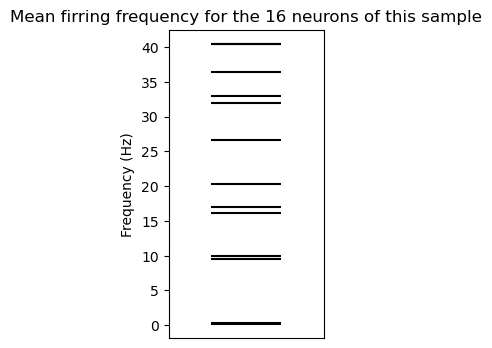

In [23]:
# For each spike train in the data set, compute the mean firing rate (number of spike divided by the duration of the recording)
spike_mean_frequency = [(data['SWAPark'][spike_train]['length'][0][0]/eeg_duration) for spike_train in STs]

# Let's plot that...
plt.figure(figsize=(2,4))
plt.eventplot(spike_mean_frequency, colors='k', orientation='vertical', linelengths=0.2)
plt.ylabel('Frequency (Hz)')
plt.title('Mean firring frequency for the 16 neurons of this sample')
plt.xticks([])
plt.show()

We cannot see any tendency here, let's continue...

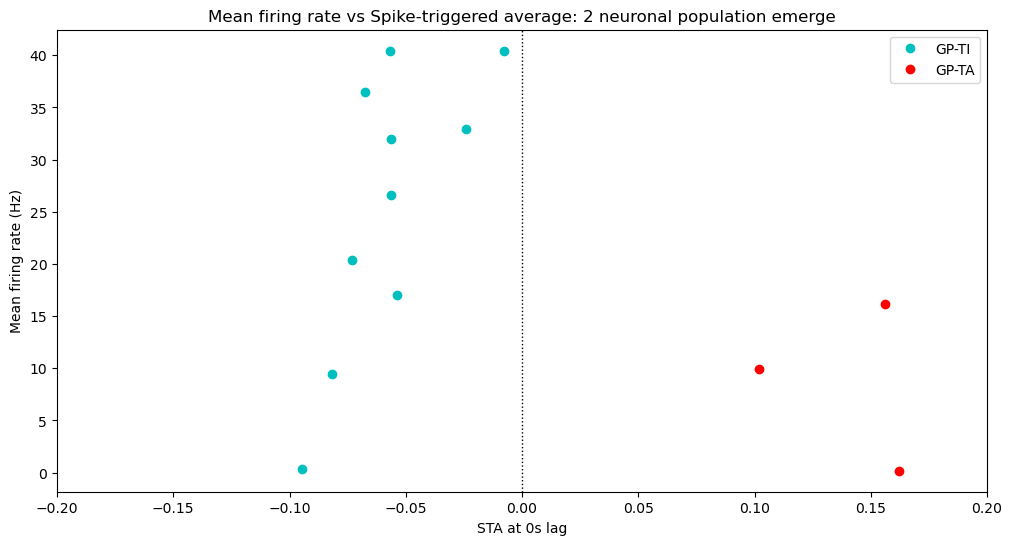

In [24]:
# Plot the mean firing rate of the spike trains vs the value of the spike-triggered average at 0 time lag
plt.figure(figsize=(12,6))

# We can plot every values in a same uniform color...
# plt.plot(list(STa.values()), list(STt.values()), 'o', color='k')

# Or we can separate our two groups depending on the population:
# First, split our two datasets
# STA
GP_TI_STA = [STA for STA in STAs if STA < 0]
GP_TA_STA = [STA for STA in STAs if STA >= 0]
# Firing average
GP_TI_avg = [SMF for SMF in spike_mean_frequency if STAs[spike_mean_frequency.index(SMF)] < 0]
GP_TA_avg = [SMF for SMF in spike_mean_frequency if STAs[spike_mean_frequency.index(SMF)] >= 0]

# Then, plot them with different colors
plt.plot(GP_TI_STA, GP_TI_avg, 'o', color='c', label='GP-TI')
plt.plot(GP_TA_STA, GP_TA_avg, 'o', color='r', label='GP-TA')

# Refine figure parameters
plt.axvline(0, color='k', linewidth=1, linestyle=':')
plt.xlim(-0.2, 0.2)
plt.xlabel('STA at 0s lag')
plt.ylabel('Mean firing rate (Hz)')
plt.title('Mean firing rate vs Spike-triggered average: 2 neuronal population emerge')
plt.legend()
plt.show()

Here, we can see a clear demarcation between two groups of neurons, suggesting 2 different neuronal population